## The following code is used for object identification and classifying the objects based on their types. 
In my case, the objects are images of cars and they are classified on the basis of the type of car. The algorithm used for the classification is ResNet.

The contents for this code has been taken from online source () . This example of code is not written by me but I used it for my object classification exercise. The intention of showing this code is to show that I can work with complex and much involved architecture of Neural Networks.

# Loading Modules

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

import scipy.io as sio

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
from fastai import ImageItemList

ImportError: ignored

# The path to the image data set.

In [0]:
path = "/content/drive/My Drive/ObjectID_Stanford_Dataset/"

In [0]:
!pwd

/content


In [0]:
PATH = Path(path)
list(PATH.iterdir())

[PosixPath('/content/drive/My Drive/ObjectID_Stanford_Dataset/car_data'),
 PosixPath('/content/drive/My Drive/ObjectID_Stanford_Dataset/anno_test.csv'),
 PosixPath('/content/drive/My Drive/ObjectID_Stanford_Dataset/anno_train.csv'),
 PosixPath('/content/drive/My Drive/ObjectID_Stanford_Dataset/names.csv'),
 PosixPath('/content/drive/My Drive/ObjectID_Stanford_Dataset/wo_year_names.csv')]

# Loading the file with the labels of different cars. 

In [0]:
path = "/content/drive/My Drive/ObjectID_Stanford_Dataset/"
labels_without_years = pd.read_csv(path + "wo_year_names.csv", header=None, names=(['class_name']))
print(labels_without_years.shape)
print(labels_without_years['class_name'][49])

(196, 1)
Buick Enclave SUV


# Mounting Google Drive to Google Colab platform

In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
#drive.mount('/content/drive')

Mounted at /content/drive


# Load the tables containing the information about the training and testing data set from the given path. 
The table consist columns named "Image_Name", "Box_x1", "Box_y1", "Box_x2", "Box_y2", "Car_Categories".  

In [0]:
import numpy as np
training_data = pd.read_csv(path + "anno_train.csv", header = None)
training_data.columns = ['Image_Name','Box_x1','Box_y1','Box_x2','Box_y2','Car_Categories']
A = np.array(labels_without_years['class_name'].loc[training_data['Car_Categories']-1]).reshape(-1,1)
training_data['class_name'] = A
testing_data = pd.read_csv(path + "anno_test.csv", header = None)
testing_data.columns = ['Image_Name','Box_x1','Box_y1','Box_x2','Box_y2','Car_Categories']
A = np.array(labels_without_years['class_name'].loc[testing_data['Car_Categories']-1]).reshape(-1,1)
testing_data['class_name'] = A
print(training_data)
print(testing_data)

     Image_Name  Box_x1  ...  Car_Categories                         class_name
0     00001.jpg      39  ...              14                     Audi TTS Coupe
1     00002.jpg      36  ...               3                     Acura TL Sedan
2     00003.jpg      85  ...              91              Dodge Dakota Club Cab
3     00004.jpg     621  ...             134        Hyundai Sonata Hybrid Sedan
4     00005.jpg      14  ...             106     Ford F-450 Super Duty Crew Cab
...         ...     ...  ...             ...                                ...
8139  08140.jpg       3  ...              78  Chrysler Town and Country Minivan
8140  08141.jpg     138  ...             196           smart fortwo Convertible
8141  08142.jpg      26  ...             163       Mercedes-Benz SL-Class Coupe
8142  08143.jpg      78  ...             112                      Ford GT Coupe
8143  08144.jpg      20  ...              17                     Audi 100 Sedan

[8144 rows x 7 columns]
     Image_Name

# Selecting the required car types from the tables.

Making a table having the required columns.

In [0]:
numb=4
training_data = training_data.loc[training_data['Car_Categories'].isin(range(1,3))] # train_df in stanford_car notebook
training_data['is_test'] = 0
print(training_data)
testing_data = testing_data.loc[testing_data['Car_Categories'].isin(range(1,3))] # test_df in stanford_car notebook
testing_data['is_test'] = 1
print(testing_data)

# labels_df is defined exactly the same way as in stanford_car notebook

frames = [training_data, testing_data]
labels_df = pd.concat(frames)
labels_df.reset_index(inplace=True, drop=True)
labels_df = labels_df[['Image_Name','Box_x1','Box_y1','Box_x2','Box_y2','Car_Categories','class_name','is_test']]

# adjust the test file names
labels_df['Image_Name'].loc[labels_df['is_test']==1] = labels_df['Image_Name']

# Add the cropped file names
labels_df['filename_rename'] = labels_df['Image_Name'].copy()
labels_df['filename_rename'].loc[labels_df['is_test']==1] = 'test_' + labels_df['Image_Name']

print(labels_df)

     Image_Name  Box_x1  Box_y1  ...  Car_Categories             class_name  is_test
162   00163.jpg      46      84  ...               1  AM General Hummer SUV        0
461   00462.jpg       5       8  ...               1  AM General Hummer SUV        0
521   00522.jpg       6       7  ...               1  AM General Hummer SUV        0
669   00670.jpg      97      49  ...               2         Acura RL Sedan        0
690   00691.jpg      84     189  ...               2         Acura RL Sedan        0
...         ...     ...     ...  ...             ...                    ...      ...
7896  07897.jpg      18     141  ...               2         Acura RL Sedan        0
7959  07960.jpg       2      24  ...               2         Acura RL Sedan        0
7965  07966.jpg      79     469  ...               1  AM General Hummer SUV        0
8010  08011.jpg      10       6  ...               1  AM General Hummer SUV        0
8030  08031.jpg      12      16  ...               1  AM General 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Counting the unique labels in the list. 

In [0]:
labels_df['filename_rename'].nunique(), labels_df['class_name'].nunique()

(153, 2)

# Finding the height and width of the images using bounding box coordinates.

In [0]:
#labels_df['bb_xy'] = tuple(labels_df[col] for col in ['bbox_x1','bbox_y1'])
labels_df['Box_h'] = (labels_df['Box_y2'] - labels_df['Box_y1'])
labels_df['Box_w'] = (labels_df['Box_x2'] - labels_df['Box_x1'])
labels_df.head()

,Image_Name,Box_x1,Box_y1,Box_x2,Box_y2,Car_Categories,class_name,is_test,filename_rename,Box_h,Box_w
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe,0,00001.jpg,259,530
1,00002.jpg,36,116,868,587,3,Acura TL Sedan,0,00002.jpg,471,832
2,00010.jpg,21,110,623,367,58,Chevrolet Traverse SUV,0,00010.jpg,257,602
3,00011.jpg,51,93,601,393,49,Buick Verano Sedan,0,00011.jpg,300,550
4,00017.jpg,39,52,233,150,14,Audi TTS Coupe,0,00017.jpg,98,194


In [0]:
bb_hw = labels_df[['Box_x1', 'Box_y1','Box_h', 'Box_w']].values
hw_bb = labels_df[['Box_h', 'Box_w', 'Box_x1', 'Box_y1']].values
bb_hw

array([[ 39, 116, 259, 530],
       [ 36, 116, 471, 832],
       [ 21, 110, 257, 602],
       [ 51,  93, 300, 550],
       ...,
       [ 23,  18, 441, 617],
       [ 33,  27, 225, 569],
       [ 33, 142, 234, 488],
       [ 77,  73, 307, 429]])

# Making a single folder for each training and testing set of images.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil   

DATADIR = "/content/drive/My Drive/ObjectID_Stanford_Dataset/car_data/test/"
DATADIR1 = "/content/drive/My Drive/ObjectID_Stanford_Dataset/car_data/test/"

#CATEGORIES = labels_without_years['Car Names']
CATEGORIES = np.array([labels_without_years['class_name'][i] for i in range(120,196)])
print(CATEGORIES.shape)

source = DATADIR
destination = DATADIR1 + "Testing_Set_3/"

image_list = []
IMG_SIZE = 160
i = 0
    
for category in CATEGORIES:  # do dogs and cats
    print(category)
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    i = i+1
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        shutil.copy(source+category+'/'+img, destination + 'test_'+img) 

(76,)
GMC Acadia SUV
GMC Canyon Extended Cab
Geo Metro Convertible
HUMMER H3T Crew Cab
HUMMER H2 SUT Crew Cab
Honda Odyssey Minivan 1
Honda Odyssey Minivan 2
Honda Accord Coupe
Honda Accord Sedan
Hyundai Veloster Hatchback
Hyundai Santa Fe SUV
Hyundai Tucson SUV
Hyundai Veracruz SUV
Hyundai Sonata Hybrid Sedan
Hyundai Elantra Sedan
Hyundai Accent Sedan
Hyundai Genesis Sedan
Hyundai Sonata Sedan
Hyundai Elantra Touring Hatchback
Hyundai Azera Sedan
Infiniti G Coupe IPL
Infiniti QX56 SUV
Isuzu Ascender SUV
Jaguar XK XKR
Jeep Patriot SUV
Jeep Wrangler SUV
Jeep Liberty SUV
Jeep Grand Cherokee SUV
Jeep Compass SUV
Lamborghini Reventon Coupe
Lamborghini Aventador Coupe
Lamborghini Gallardo LP 570-4 Superleggera
Lamborghini Diablo Coupe
Land Rover Range Rover SUV
Land Rover LR2 SUV
Lincoln Town Car Sedan
MINI Cooper Roadster Convertible
Maybach Landaulet Convertible
Mazda Tribute SUV
McLaren MP4-12C Coupe
Mercedes-Benz 300-Class Convertible
Mercedes-Benz C-Class Sedan
Mercedes-Benz SL-Class C

# Calling ResNet152 architecture of neural network for training the machine to identify objects. 

In [0]:
arch = models.resnet152

# Split the training images transfered into a single folder into training and validation set.

In [0]:
SZ = 224
SEED = 42
LABEL = 'class_name'
path = "/content/drive/My Drive/ObjectID_Stanford_Dataset/"

car_tfms = get_transforms()

trn_labels_df = labels_df.loc[labels_df['is_test']==0, ['Image_Name', 'class_name', 'Car_Categories', 'filename_rename']].copy()

src = (ImageList.from_df(trn_labels_df, path + 'car_data/' , folder='train/Training_Set', cols='filename_rename')
                    .split_by_rand_pct(valid_pct=0.2, seed=SEED)
                    .label_from_df(cols=LABEL))

data = (src.transform(car_tfms, size=SZ)
            .databunch()
            .normalize(imagenet_stats))

print(trn_labels_df.shape)
print(data)

You can deactivate this warning by passing `no_check=True`.
(77, 4)
ImageDataBunch;

Train: LabelList (62 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
AM General Hummer SUV,AM General Hummer SUV,Acura RL Sedan,AM General Hummer SUV,AM General Hummer SUV
Path: /content/drive/My Drive/ObjectID_Stanford_Dataset/car_data;

Valid: LabelList (15 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Acura RL Sedan,Acura RL Sedan,Acura RL Sedan,AM General Hummer SUV,AM General Hummer SUV
Path: /content/drive/My Drive/ObjectID_Stanford_Dataset/car_data;

Test: None


/usr/local/lib/python3.6/dist-packages/fastai/basic_data.py:248: UserWarning: Your training dataloader is empty, you have only 62 items in your training set.
                 Your batch size is 64, you should lower it.
  Your batch size is {self.train_dl.batch_size}, you should lower it.""")


# Defining the batch size for training images while inputing into the model.

In [0]:
data.batch_size = 32
data.batch_size

32

# Compiling the ResNet model.

In [0]:
learn = cnn_learner(data, arch, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


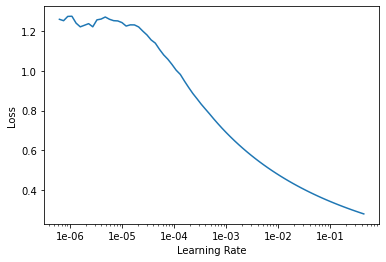

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2

In [0]:
learn.fit_one_cycle(20, max_lr = lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.485371,0.279783,0.866667,00:02
1,0.926021,0.002626,1.000000,00:01
2,0.612603,0.000060,1.000000,00:01
3,0.457427,0.000001,1.000000,00:01
4,0.362221,0.000001,1.000000,00:01
5,0.305486,0.002252,1.000000,00:01
6,0.259281,0.622828,0.800000,00:01
7,0.255737,0.356728,0.933333,00:01
8,0.227327,0.425298,0.933333,00:02
9,0.202568,0.018978,1.000000,00:01


In [0]:
learn.save('stage-1_class_2-rn152-bench')

In [0]:
learn.unfreeze()

# Compiling model for another batch size. 

In [0]:
data.batch_size = 16
data.batch_size

16

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


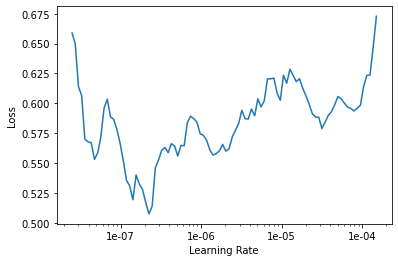

In [0]:
learn.lr_find(start_lr=1e-8, end_lr=9e-1, num_it=200)
learn.recorder.plot()

In [0]:
lr = 1e-7
lrs = np.array([lr/100,lr/10,lr])

In [0]:
learn.fit_one_cycle(5, lrs)

epoch,train_loss,valid_loss,accuracy,time
0,0.371123,0.771714,0.743902,00:40
1,0.384908,0.767987,0.762195,00:40
2,0.368348,0.768705,0.746951,00:39
3,0.352704,0.763301,0.750000,00:38
4,0.367411,0.765306,0.750000,00:38


In [0]:
learn.save('stage-2-rn152-bench')

In [0]:
# Testing with higher LR and unfrozen layers
learn.load('stage-1_class_2-rn152-bench')
learn.unfreeze()
#data.batch_size = 16

#lr = 1e-3
#lrs = np.array([lr/100,lr/10,lr])

#learn.fit_one_cycle(6, lrs)

# Loading and preparing the test set data to fed into ResNet architecture.

In [0]:
SZ = 224
SEED = 42
LABEL = 'class_name'
path = "/content/drive/My Drive/ObjectID_Stanford_Dataset/"

car_tfms = get_transforms()
trn_labels_df = labels_df.loc[labels_df['is_test']==1, ['Image_Name','is_test', 'class_name', 'Car_Categories']].copy()
print(labels_df)
src = (ImageList.from_df(labels_df, path + 'car_data/' , folder='test/Testing_Set_3', cols='filename_rename')
       # the 'is_test' column has values of 1 for the test set
       .split_from_df(col='is_test')
       .label_from_df(cols=LABEL))

data_test = (src.transform(car_tfms, size=SZ)
            .databunch()
            .normalize(imagenet_stats))

print(trn_labels_df.shape)            
print(data_test)

    Image_Name  Box_x1  Box_y1  ...             class_name  is_test  filename_rename
0    00163.jpg      46      84  ...  AM General Hummer SUV        0        00163.jpg
1    00462.jpg       5       8  ...  AM General Hummer SUV        0        00462.jpg
2    00522.jpg       6       7  ...  AM General Hummer SUV        0        00522.jpg
3    00670.jpg      97      49  ...         Acura RL Sedan        0        00670.jpg
4    00691.jpg      84     189  ...         Acura RL Sedan        0        00691.jpg
..         ...     ...     ...  ...                    ...      ...              ...
148  07530.jpg      70      94  ...  AM General Hummer SUV        1   test_07530.jpg
149  07841.jpg     129     213  ...         Acura RL Sedan        1   test_07841.jpg
150  07917.jpg      87       6  ...  AM General Hummer SUV        1   test_07917.jpg
151  07948.jpg       5       4  ...  AM General Hummer SUV        1   test_07948.jpg
152  08035.jpg      10      18  ...  AM General Hummer SUV       

# Compiling the test data.

In [0]:
learn.data = data_test

In [0]:
test_preds, test_ys = learn.TTA()

In [0]:
test_preds.shape

torch.Size([245, 6])

# Evaluating the Accuracy Score.

In [0]:
accuracy(test_preds, test_ys)

tensor(0.9079)

# The Accuracy Score with different Number of Classes from ResNet model.

In [0]:
accuracy_resnet = [[2,90.79],[4,85.09],[6,82.45], [8,83.28], [10,77.42], [20,73.59], [40,77.84], [60,81.15], [80,80.73], [100,81.78], [120,83.96], [140,83.24], [160,84.18], [180,84.16] , [196,84.85]]